# Segmenter les clients d'un site d'e-commerce
Dans ce Notebook, nous réaliserons une segmentation des client pour l'entreprise [Olist](https://olist.com/pt-br/) afin de permettre à ses équipes de e-commerce de l'utilisez pour leurs campagnes de communication. Notre objectif sera de comprendre les différents types d'utilisateurs grâce à leur comportement et à leur données personnelles.  


![Olist](https://user.oc-static.com/upload/2019/02/24/15510251487267_Capture%20d%E2%80%99e%CC%81cran%202019-02-20%20a%CC%80%2017.37.38.png)  


Olist exploite un site de commerce électronique en ligne destiné aux vendeurs, qui met en relation les commerçants et leurs produits avec les principales places de marché du Brésil. Olist a été fondée en 2015 par Tiago Dalvi. La société a son siège à Curitiba, Parana, au Brésil. Le produit phare d'Olist, Olist Store, offre aux commerçants un moyen de gérer les annonces de produits, la logistique et les paiements de magasin. Il propose également "une expérience de vente unique" à travers des canaux tels que Mercado Livre, B2W et Via Varejo. Olist a attiré plus de 200 000 utilisateurs dans 180 pays. La société compte plus de 45 000 commerçants et détaillants parmi ses clients.

## Utilisation de méthodes non supervisées pour le regroupement des clients de profils similaires.

### Introduction :  


Dans un paysage numérique en constante évolution, la compréhension des diverses typologies de clients revêt une importance capitale pour les entreprises opérant dans le domaine de l'e-commerce.  


Notre étude vise à disséquer et à catégoriser les utilisateurs de la plateforme [Olist](https://olist.com/pt-br/) en fonction de leurs comportements et de leurs données personnelles. En analysant ces paramètres cruciaux, nous cherchons à élucider les tendances, motivations et préférences qui sous-tendent les interactions des clients, afin d'optimiser leur expérience sur le site [Olist](https://olist.com/pt-br/) et de maximiser la valeur qu'ils en tirent.  


Cette segmentation fine permettra d'adapter la stratégies de marketing de la plateforme, d'améliorer la personnalisation des offres et de cibler efficacement les campagnes, renforçant ainsi la satisfaction et la fidélité de leur clientèle. La présente étude offre une vue d'ensemble détaillée des différentes cohortes d'utilisateurs, apportant ainsi des insights fondamentaux pour l'orientation stratégique de leur plateforme e-commerce.

## Table des matières


#### [1.Présentation des données](#1.-Présentation-des-données)
#### [2.Nettoyage du Dataset](#2.-Nettoyage-du-Dataset)
#### - [A.Traitement des valeurs aberrantes](#A.-Traitement-des-valeurs-aberrantes)
#### - [B.Traitement des valeurs manquantes](#B.-Traitement-des-valeurs-manquantes)

#### [3.Analyse exploratoire du Dataset](#3.-Analyse-exploratoire-du-Dataset)
#### - [A.Analyse univariées](#A.-Analyse-univariées)
#### - [B.Analyse bivariées](#B.-Analyse-bivariées)
#### - [C.Analyse multivariées](#C.-Analyse-multivariées)

## 1. Présentation des données

## Import
Nous utiliserons une stack de Data Science habituelle : `numpy`, `pandas`, `sklearn`, `matplotlib`.

In [81]:
#manipulation des données
import numpy as np
import pandas as pd 

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes 
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Import du Dataset
Tout d’abord, nous pouvons lister tous les fichiers de données disponibles. Il y a au total 9 fichiers organisés comme suit :
![image](https://i.imgur.com/HRhd2Y0.png)

In [82]:
print(os.listdir("./archive/"))

['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'brazilian_states_csv.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


Nous importons les fichiers dont les données nous serons utile pour l'étude de cluestering des individus.

In [83]:
olist_orders_dataset = pd.read_csv('./archive/olist_orders_dataset.csv', sep=',')#
olist_sellers_dataset = pd.read_csv('./archive/olist_sellers_dataset.csv', sep=',')#
product_category_name_translation = pd.read_csv('./archive/product_category_name_translation.csv', sep=',')
olist_order_items_dataset = pd.read_csv('./archive/olist_order_items_dataset.csv', sep=',')#
olist_customers_dataset = pd.read_csv('./archive/olist_customers_dataset.csv', sep=',')#
olist_geolocation_dataset = pd.read_csv('./archive/olist_geolocation_dataset.csv', sep=',')#
olist_order_payments_dataset = pd.read_csv('./archive/olist_order_payments_dataset.csv', sep=',')#
olist_order_reviews_dataset = pd.read_csv('./archive/olist_order_reviews_dataset.csv', sep=',')#
olist_products_dataset = pd.read_csv('./archive/olist_products_dataset.csv', sep=',')#

La clef `geolocation_zip_code_prefix` permettant de fusionner les dataframe possède différentes géolocalisation pour une même clef. Nous pouvons simplifier le travail de fusion des dataframe en attribuant à une clef une seule valeurs de localisation.

In [84]:
olist_geolocation_dataset = olist_geolocation_dataset.drop_duplicates(subset=['geolocation_zip_code_prefix'])
olist_geolocation_dataset

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
...,...,...,...,...,...
999774,99955,-28.107588,-52.144019,vila langaro,RS
999780,99970,-28.345143,-51.876926,ciriaco,RS
999786,99910,-27.863500,-52.084760,floriano peixoto,RS
999803,99920,-27.858716,-52.300403,erebango,RS


Nous fusionnons les différents Dataframe pour simplifier notre travail d'analyse des différents individus et de leurs caractéristiques.

In [85]:
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_payments_dataset, on='order_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_reviews_dataset, on='order_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_order_items_dataset, on='order_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_products_dataset, on='product_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_sellers_dataset, on='seller_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_geolocation_dataset, left_on='seller_zip_code_prefix',\
                                 right_on='geolocation_zip_code_prefix')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_customers_dataset, on='customer_id')
olist_orders_dataset = pd.merge(olist_orders_dataset, olist_geolocation_dataset, left_on='customer_zip_code_prefix',\
                                 right_on='geolocation_zip_code_prefix')

In [86]:
olist_orders_dataset = olist_orders_dataset.drop(columns=['geolocation_zip_code_prefix_x', 'geolocation_city_x', 'geolocation_state_x', \
                                                          'geolocation_zip_code_prefix_y', 'geolocation_state_y'])
pd.set_option('display.max_columns', None) #permet d'afficher toutes les colonnes

Nous passons également par étape de traduction pour simplifier notre compréhension des données.

In [87]:
olist_orders_dataset = pd.merge(olist_orders_dataset, product_category_name_translation, on='product_category_name')
olist_orders_dataset = olist_orders_dataset.drop(columns=['product_category_name'])
olist_orders_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,-23.574809,-46.587471,sao paulo,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,-23.565578,-46.534603,sao paulo,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,-23.543295,-46.630743,sao paulo,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115032,25af0443015b8d200489039a00361f2e,1674ec99b39d56ec2aa232

Pour permettre une bonne compréhension des variables qui caractérisent chaque individus il est important d'avoir une explication clair du sens de chaque variable :  

 - `order_id` : identifiant unique de la commande
 - `customer_id` : clef des commande identifiant un client chaque commande à un identifiant unique.
 - `order_status` : Référence au statut de la commande (livrée, expédiée, etc.).
 - `order_purchase_timestamp` : Affiche l'horodatage de l'achat.
 - `order_approved_at` : Affiche l'horodatage de l'approbation du paiement.
 - `order_delivered_carrier_date` : Affiche l'horodatage de publication de la commande. Quand il a été remis au partenaire logistique.
 - `order_delivered_customer_date` : Affiche la date réelle de livraison de la commande au client.
 - `order_estimated_delivery_date` : Affiche la date de livraison estimée qui a été informée au client au moment de l'achat.
 - `payment_sequential` : un client peut payer une commande avec plusieurs modes de paiement. S'il le fait, une séquence sera créée pour accueillir tous les paiements.
 - `payment_type` : mode de paiement choisi par le client.
 - `payment_installments` : nombre de versements choisi par le client.
 - `payment_value` : valeur transactionnelle.
 - `review_id` : identifiant d'avis
 - `review_score` : Note allant de 1 à 5 donnée par le client sur une enquête de satisfaction.
 - `review_comment_title` : Titre du commentaire issu de l'avis laissé par le client, en portugais.
 - `review_comment_message` : Message de commentaire de l'avis laissé par le client, en portugais.
 - `review_creation_date` : Indique la date à laquelle l'enquête de satisfaction a été envoyée au client.
 - `review_answer_timestamp` : Affiche l'horodatage des réponses à l'enquête de satisfaction.
 - `order_item_id` : numéro séquentiel identifiant le nombre d’articles inclus dans la même commande.
 - `product_id` :identifiant unique du produit
 - `seller_id` : identifiant unique du vendeur
 - `shipping_limit_date` : Affiche la date limite d'expédition du vendeur pour le traitement de la commande vers le partenaire logistique.
 - `price` : prix de l'article
 - `freight_value` : article valeur du fret article (si une commande contient plus d'un article, la valeur du fret est répartie entre les articles)
 - `product_name_lenght` : nombre de caractères extraits du nom du produit.
 - `product_description_lenght` : nombre de caractères extraits de la description du produit.
 - `product_photos_qty` : nombre de photos de produits publiées
 - `product_weight_g` : poids du produit mesuré en grammes.
 - `product_length_cm` : longueur du produit mesurée en centimètres.
 - `product_height_cm` : hauteur du produit mesurée en centimètres.
 - `product_width_cm` : largeur du produit mesurée en centimètres.
 - `seller_zip_code_prefix` : 5 premiers chiffres du code postal
 - `seller_city` : Nom de Ville
 - `seller_state` : État
 - `geolocation_lat_x` : latitude
 - `geolocation_lng_x` : longitude
 - `customer_unique_id` : identifiant unique d'un client.
 - `customer_zip_code_prefix` : cinq premiers chiffres du code postal du client
 - `customer_city` : nom de la ville du client
 - `customer_state` : état du client
 - `product_category_name_english` : catégorie du produit

Nous pouvons désormais passer à une première étape d'analyse de nos données. Nous transformons le nom du dataframe et affichons le type de valeurs de chaque caractéristique.

In [88]:
data = olist_orders_dataset.copy()
data.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
review_id                         object
review_score                       int64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
product_name_len

Nous pouvons également étudier la distribution de chaque variable pour tenter de mettre en avant les valeurs aberrantes ou atypiques qui pourraient biaiser la généralisation de notre modèle de Machine Learning

In [89]:
data.describe()

,payment_sequential,payment_installments,payment_value,review_score,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,geolocation_lat_x,geolocation_lng_x,customer_zip_code_prefix,geolocation_lat_y,geolocation_lng_y
count,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115036.000000,115036.000000,115036.000000,115036.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000,115037.000000
mean,1.094057,2.944566,172.409294,4.034319,1.194685,120.650015,20.049325,48.754288,785.867573,2.200318,2112.365746,30.300897,16.658716,23.104089,24523.886054,-22.796059,-47.247909,34983.378296,-21.235765,-46.197857
std,0.731544,2.780108,266.204508,1.385651,0.686686,182.853114,15.850423,10.038336,653.051492,1.713213,3776.693083,16.203684,13.484108,11.730325,27644.643367,2.696612,2.346336,29829.438971,5.571871,4.050645
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,-36.605374,-67.809656,1003.000000,-36.605374,-72.666706
25%,1.000000,1.000000,60.850000,4.000000,1.000000,39.900000,13.080000,42.000000,345.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,-23.611654,-48.831547,11095.000000,-23.590023,-48.101695
50%,1.000000,2.000000,108.000000,5.000000,1.000000,74.900000,16.320000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13720.000000,-23.420739,-46.755211,24230.000000,-22.929912,-46.632021
75%,1.000000,4.000000,189.430000,5.000000,1.000000,134.900000,21.200000,57.000000,982.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28470.000000,-21.766477,-46.518082,58297.000000,-20.198222,-43.625993
max,29.000000,24.000000,13664.080000,5.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,-2.546079,-34.847856,99980.000000,42.184003,-8.577855


## 2. Nettoyage du Dataset

Nous pouvons remarquer plusieurs valeurs atypique parmis les individus, nous devons analyser ces valeurs pour s'assurer que ce ne sont pas des valeurs aberrantes qui n'ont rien à faire dans les données et que nous devrions alors corriger.

In [90]:
data[data['payment_value'] > 10000]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
111892,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,211fa81a22870cc634265ea85b751e40,1,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,1,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
111893,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,211fa81a22870cc634265ea85b751e40,1,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,2,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
111894,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,211fa81a22870cc634265ea85b751e40,1,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,3,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
111895,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,211fa81a22870cc634265ea85b751e40,1,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,4,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
111896,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,2017-10-17 18:22:29,2017-10-23 00:00:00,1,credit_card,1,13664.08,211fa81a22870cc634265ea85b751e40,1,NaN,"Peço por favor verificar a entrega do pedido, ...",2017-10-18 00:00:00,2017-10-19 13:10:39,5,5769ef0a239114ac3a854af00df129e4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,39.0,2493.0,3.0,750.0,16.0,16.0,16.0,3667,sao paulo,SP,-23.532047,-46.496814,0a0a92112bd4c708ca5fde585afaa872,20080,rio de janeiro,RJ,-22.901095,-43.182559,rio de janeiro,fixed_telephony
111897,03caa2c082116e1d31e67e9ae3700499,1617b1357756262bfa56ab541c

In [91]:
data.loc[111892]['review_comment_message']

'Peço por favor verificar a entrega do pedido, pois não recebemos.'

Il semblerait que malgré le montant exorbitant par rapport aux autres valeurs constatées soit bien correct et correspond à 8 achats d'un montant de 1680 et de 8 livraison de 28.01. Le client indique seulement ne pas avoir reçu sa commande.

In [92]:
data[data['product_weight_g'] > 20000]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
26,9d4ff04268ad793e7cac36f6224d44dc,bbbb6bbcabbb1712d83b6d996869b412,delivered,2018-08-13 14:36:26,2018-08-13 14:50:18,2018-08-15 11:14:00,2018-08-20 18:51:40,2018-08-24 00:00:00,1,credit_card,20,811.32,a1862ee7ae84585d9f82be983ca0f7c6,5,NaN,NaN,2018-08-21 00:00:00,2018-08-23 23:46:24,1,0fb3fae6c3a74bc9fd48a66d0be5f378,5e105f5c9f63f5f1fd75d6cb942e55b1,2018-08-17 14:50:18,749.00,62.32,45.0,448.0,2.0,22050.0,70.0,35.0,51.0,15076,sao jose do rio preto,SP,-20.830233,-49.357775,219291a07997c4fc9a962719151bfa38,13820,monte alegre do sul,SP,-22.689713,-46.982493,jaguariuna,housewares
100,303a73983ac1421570602e1812ea3bbd,cd44b9d8c8dbe3fef291203c1b8977ce,delivered,2018-06-19 21:38:16,2018-06-20 13:57:48,2018-06-21 15:35:00,2018-06-25 22:51:57,2018-07-03 00:00:00,1,boleto,1,448.91,1e24c486cc63ed0d0240a6fdaa9788ff,5,Bom,NaN,2018-06-26 00:00:00,2018-07-04 02:46:06,1,59f09deeea7c839a9212a19f3416b892,729f06993dac8e860d4f02d7088ca48a,2018-06-25 13:57:48,379.90,69.01,58.0,1404.0,4.0,30000.0,60.0,66.0,29.0,13481,limeira,SP,-22.599254,-47.379810,fda2e2ffa2ddf9458f9151448ee6a57c,11700,praia grande,SP,-24.016284,-46.398436,praia grande,housewares
292,479ca7b6834ffb05666e813c9c0dddf8,7736f29fbade4b21885578b5030282dc,delivered,2018-05-21 11:15:00,2018-05-23 14:14:39,2018-06-01 14:04:00,2018-06-15 00:49:38,2018-06-06 00:00:00,1,credit_card,5,376.69,eaec24296e760c48c2bf5fb830984235,1,NaN,NaN,2018-06-10 00:00:00,2018-06-10 11:12:42,1,ac850a749748b386d598124ae34ba1b0,fffd5413c0700ac820c7069d66d98c89,2018-05-28 14:14:39,298.60,78.09,34.0,665.0,4.0,24200.0,40.0,90.0,60.0,13908,amparo,SP,-22.722821,-46.841798,edd3f97254cf3ce5e95da8245dea95dd,3337,sao paulo,SP,-23.556169,-46.564805,sao paulo,housewares
369,33385120d1dbb98e6fafeeb955d5b28c,00d8b72b2807894a9e5c690179132819,delivered,2017-11-08 00:04:42,2017-11-08 01:26:56,2017-11-09 17:21:47,2017-11-10 20:34:41,2017-11-23 00:00:00,1,credit_card,3,422.16,d068a49ebf18f0851cff849226c22416,5,NaN,NaN,2017-11-11 00:00:00,2017-11-11 23:25:55,1,59f09deeea7c839a9212a19f3416b892,729f06993dac8e860d4f02d7088ca48a,2017-11-16 01:26:26,359.90,62.26,58.0,1404.0,4.0,30000.0,60.0,66.0,29.0,13481,limeira,SP,-22.599254,-47.379810,f87567b082c73dd2c953001b14ddd739,8588,itaquaquecetuba,SP,-23.443063,-46.320468,itaquaquecetuba,housewares
491,9814a337a2470787f24426bf0af8b16b,be2abc57e92c541f83e8be9e8a8fd1af,delivered,2018-04-02 11:02:38,2018-04-02 11:15:21,2018-04-03 22:56:50,2018-04-04 15:29:04,2018-04-12 00:00:00,1,credit_card,1,192.55,f22ec54dbad130177184ba1cbde4f1e5,5,NaN,NaN,2018-04-05 00:00:00,2018-04-10 11:12:44,1,53a49e6f80917f8d611ec74ccf84c157,febab0275244b9a49a623f0bd613ca2f,2018-04-06 11:15:21,142.00,50.55,56.0,757.0,1.0,20450.0,43.0,79.0,41.0,13920,pedreira,SP,-22.738242,-46.895859,128ea331ccb1962fae3956011d60385f,4614,sao paulo,SP,-23.616739,-46.673398,sao paulo,housewares
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114747,87fcaa805e96b64e38168bbb1852225b,61904f4433f98a2b17c4c483c179c8a2,delivered,2017-05-11 14:57:00,2017-05-11 15:10:21,2017-05-13 07:41:46,2017-05-25 18:39:20,2017-05-31 00:00:00,1,cred

Nous ne remarquons pas à proprement parler de valeurs aberrantes dans les données mais certaines peuvent sembler atypique. Cela s'explique par le fait que `Olist` vend une large variété de produits.

Nous pouvons désormais étudier les valeurs manquantes des données pour nous permettre de réaliser correctement notre étude.

<Axes: >

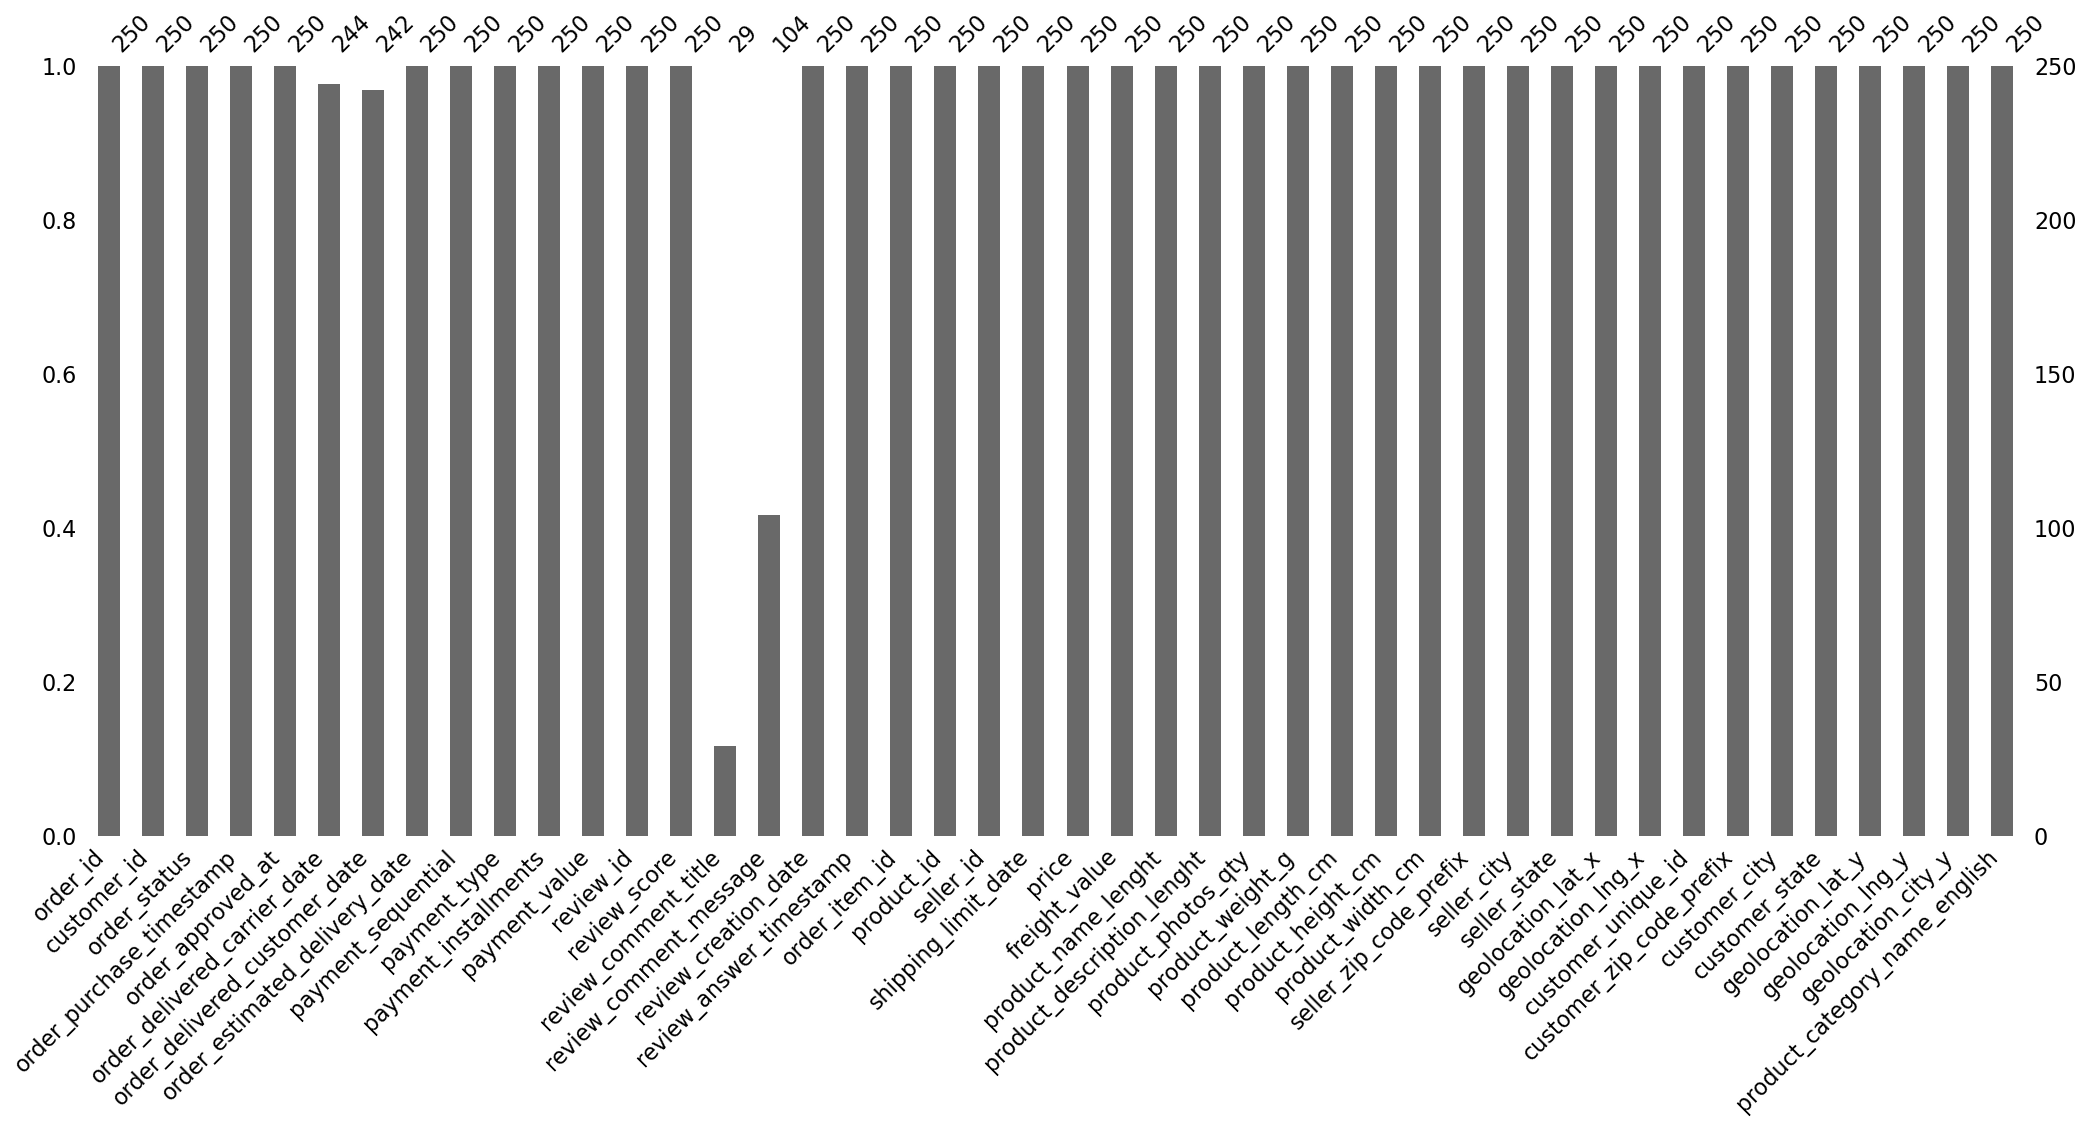

In [93]:
import missingno as msno
%matplotlib inline
msno.bar(data.sample(250))

Nous pouvons remarquer des valeurs manquantes dans `order_delivered_customer_date`, dans `order_delivered_delivered_date`, dans `review_comment_title` et dans `review_comment_message`. Les dates manquantes correspondent à des clients qui n'ont pas encore été livré ou qui dont le colis n'a pas encore donné au livreur, nous remplaçons ces valeurs manquantes par des valeurs neutre qui nous permettrons d'être correctement utilisé plus tard. Pour les 2 autres variables qui disposent de valeurs manquantes nous remplacerons ces valeurs par `no title` et `no comment` pour bien les identifier dans la suite de notre étude.

In [94]:
date_neutre_carrier = pd.to_datetime('1900-01-01 00:00:00')
date_neutre_customer = pd.to_datetime('1900-02-01 00:00:00')
data['order_delivered_carrier_date'] = data['order_delivered_carrier_date'].fillna(date_neutre_carrier)
data['order_delivered_customer_date'] = data['order_delivered_customer_date'].fillna(date_neutre_customer)

In [95]:
no_title = 'no title'
no_message = 'no message'
data['review_comment_title'] = data['review_comment_title'].fillna(no_title)
data['review_comment_message'] = data['review_comment_message'].fillna(no_message)

Nous pouvons également trouver des valeurs manquantes dans la caractéristique `order_approved_at`, c'est une information étrange mais pas primordiale, habituelement un achat doit être validé avant d'être envoyé, hors ce n'est pas le cas ici, nous remplaçons les valeurs manquantes par la date d'achat du client.

In [96]:
data[data['order_approved_at'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
17402,3c0b8706b065f9919d0505d3b3343881,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaN,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23 00:00:00,1,boleto,1,157.19,8cc64d9567be9b4f56c5cd423cfc3b02,3,no title,no message,2017-03-04 00:00:00,2017-03-06 10:31:00,1,db8ed3d08891d16a2438a67ab3acb740,004c9cd9d87a3c30c522c48c4fc07416,2017-02-22 14:53:27,133.99,23.20,62.0,702.0,1.0,2700.0,42.0,11.0,36.0,14940,ibitinga,SP,-21.766477,-48.831547,c094ac95fcd52f821809ec232a7a6956,95795,sao vendelino,RS,-29.369650,-51.378081,sao vendelino,bed_bath_table
32986,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00,1,boleto,1,60.42,24f83e3e2c75b58888eec93ab93f2cca,2,no title,Não gostei. O material não é tão bom. A cor do...,2017-02-07 00:00:00,2017-02-10 10:20:44,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52,59.0,473.0,1.0,600.0,30.0,3.0,20.0,14940,ibitinga,SP,-21.766477,-48.831547,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,conselheiro lafaiete,furniture_decor
37962,51eb2eebd5d76a24625b31c33dd41449,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaN,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29 00:00:00,1,boleto,1,77.06,6352329f467fe888f25b35e48b11b97e,5,no title,no message,2017-03-09 00:00:00,2017-03-09 08:14:03,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16,59.0,438.0,1.0,1200.0,30.0,5.0,20.0,14940,ibitinga,SP,-21.766477,-48.831547,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,-22.551107,-45.777154,paraisopolis,furniture_decor
38096,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00,1,boleto,1,163.43,6540ad5bc5a8bfc9ede2d495bfb940dd,5,no title,Excelente produto,2017-03-03 00:00:00,2017-03-04 21:06:06,1,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63,54.0,586.0,1.0,1700.0,33.0,8.0,23.0,14940,ibitinga,SP,-21.766477,-48.831547,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,-23.561681,-46.506271,sao paulo,furniture_decor
42672,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaN,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21 00:00:00,1,boleto,1,127.04,331c2fea3f2c1512a9ca1889436a6904,4,no title,O serviço do site dessa vez foi otimo. \r\nEm ...,2017-03-03 00:00:00,2017-03-04 03:45:57,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52,61.0,440.0,1.0,250.0,18.0,3.0,28.0,11010,santos,SP,-23.934659,-46.331065,bc1896dc77f49e6dec880445a9b443a3,21020,rio de janeiro,RJ,-22.830107,-43.277549,rio de janeiro,telephony
42673,88083e8f64d95b932164187484d90212,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaN,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21 00:00:00,1,boleto,1,127.04,331c2fea3f2c1512a9ca1889436a6904,4,no title,O serviço do site dessa vez foi otimo. \r\nEm ...,2017-03-03 00:00:00,2017-03-

In [97]:
data['order_approved_at'].fillna(data['order_purchase_timestamp'], inplace=True)

Il semblerait qu'un achat ne possède pas de poids ni de taille, mais qu'il y a bien un montant pour l'envoi du colis. Ne s'agissant pas de la catégorie logiciel, le colis devait forcèment être physique, n'ayant pas suffisamment d'information pour remplacer les valeurs manquantes, il est préférable de supprimer l'individu afin de simplifier notre travail d'analyse.

In [98]:
Nan_values = data.isnull().sum()
total_values = len(data)
Nan_values = Nan_values[Nan_values > 0]
Nan_values_percentage = (Nan_values / total_values) * 100
Nan_values_percentage = round(Nan_values_percentage, 2)
print(Nan_values_percentage)

product_weight_g     0.0
product_length_cm    0.0
product_height_cm    0.0
product_width_cm     0.0
dtype: float64


In [99]:
data[data['product_weight_g'].isna()]
#20114

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat_x,geolocation_lng_x,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,product_category_name_english
20114,85f8ad45e067abd694b627859fa57453,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08 00:00:00,1,credit_card,10,1961.0,125af5098b160c059cd60bafcc1f6ad1,5,no title,no message,2017-02-08 00:00:00,2017-02-09 10:09:24,1,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,2017-02-03 21:40:02,1934.0,27.0,60.0,865.0,3.0,NaN,NaN,NaN,NaN,86020,londrina,PR,-23.306635,-51.16455,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,-30.049304,-51.21316,porto alegre,baby


In [100]:
index_drop = data[data['product_weight_g'].isna()].index
data.drop(index_drop, inplace=True)

## 3. Analyse exploratoire du Dataset

Nous pouvons maintenant analyser les données, ces dernières concentrent 115037 individus, caractérisé par 44 variables. Représentant 92.938 clients et 3.021 vendeurs.

In [101]:
print(len(data['customer_unique_id'].unique()))#nombre de clients unique
print(len(data['seller_id'].unique())) # nombre de vendeurs unique
print(data['customer_unique_id'].value_counts()[data['customer_unique_id'].value_counts() > 1].shape) #nombre de clients qui commande plusieurs fois
print((13948/(len(data['customer_unique_id'].unique())))*100) #pourcentage de client récurrent
print(len(data['product_category_name_english'].unique())) #nombre de catégorie de produits

92938
3021
(13948,)
15.00785469883148
71


In [102]:
len(data['customer_state'].unique())

27

In [103]:
resultats = data.groupby('customer_state')['customer_unique_id'].unique()
customer_nb = []

for state, customer in resultats.items():
    customer_nb.append({'States' : state, 'Nombre de clients' : len(customer)})

df_clients = pd.DataFrame(customer_nb)

In [104]:
seller_filter = data.groupby('customer_state')['seller_id'].unique()
seller_nb = []

for state, seller in seller_filter.items():
    seller_nb.append({'States' : state, 'Nombre de vendeurs' : len(seller)})

df_brazilian_population = pd.read_csv('./archive/brazilian_states_csv.csv')

df_sellers = pd.DataFrame(seller_nb)
df_states = pd.merge(df_clients, df_sellers, on='States')
df_states = pd.merge(df_states, df_brazilian_population, on='States')
df_states

,States,Nombre de clients,Nombre de vendeurs,Population
0,AC,74,68,795145
1,AL,391,246,3327551
2,AM,140,116,3893763
3,AP,66,62,756500
4,BA,3163,935,15150143
5,CE,1274,514,8867448
6,DF,1858,743,2867869
7,ES,1907,720,3894899
8,GO,1873,698,6551322
9,MA,702,363,6861924


### Analyse exploratoire
 - X etudier la distribution des valeurs pour montrer les valeurs aberrantes 
 - X etudier les valeurs manquantes
 - X traduire la catégorie de produit
 - X montrer le nombre de client
 - X montrer le nombre de vendeur
 - X montrer la concentration d'acheteur par région
 - X montrer la concentration de vendeur par région
 - X montrer la concentration en fonction du nombre d'habitant par région
 - montrer les région qui rapporte de l'argent
 - montrer le délais entre l'achat et la livraison et le rating du produits
 - montrer le panier moyen d'un client
 - montrer le prix de livraison en fonction du cubage du colis
 - montrer la distance entre le client et le vendeur et le délais de livraison
 - montrer le nombre de client payant a crédit et le montant moyen
 - montrer les date d'achat
 - montrer le nombre de client récurrent
 - montrer le délais entre plusieurs achats


test supplémentaire